In [47]:
%matplotlib widget

import xarray as xr
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import datetime
from eomaps import Maps

In [ ]:
sig0_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E054N006T3/SIG0_20180228T043908__VV_D080_E054N006T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.nc')
hparam_dc = xr.open_dataset('data/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R3/EQUI7_EU020M/E054N006T3/D080.nc')
plia_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E054N006T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__D080_E054N006T3_EU020M_V01R03_S1IWGRDH.nc')
RANGE = np.arange(-30, 0, 0.1)



sig0_df = sig0_dc.SIG0.to_dataframe()
# IDs = range(len(sig0_df.x) * len(sig0_df.y))
sig0_df.iloc[:9]

AttributeError: 'DataFrame' object has no attribute 'isel'

In [49]:
def calc_water_prior(x, y):
    wbsc_mean = plia_dc.isel(x=x, y=y).PLIA * -0.394181 + -4.142015
    wbsc_std = 2.754041
    return norm.pdf(RANGE, wbsc_mean.to_numpy(), wbsc_std)

In [50]:
def expected_land_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.M0
    S1 = data.S1
    S2 = data.S2
    S3 = data.S3
    C1 = data.C1
    C2 = data.C2
    C3 = data.C3
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3

def calc_land_prior(x, y):
    lbsc_mean = expected_land_backscatter(hparam_dc.isel(x=x, y=y), '2018-02-01')
    lbsc_std = hparam_dc.isel(x=x, y=y).STD
    return norm.pdf(RANGE, lbsc_mean.to_numpy(), lbsc_std.to_numpy())

def calc_priors(x, y):
    return calc_water_prior(x=x, y=y), calc_land_prior(x=x, y=y)

def plot_priors(x, y):
    y1_pdf, y2_pdf = calc_priors(x = x, y = y)
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, y1_pdf, 'k-', lw=2)
    ax.vlines(x=sig0_dc.isel(x=x, y=y).SIG0.to_numpy(), ymin=0, ymax=np.max((y1_pdf, y2_pdf)), lw=3)
    ax.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)

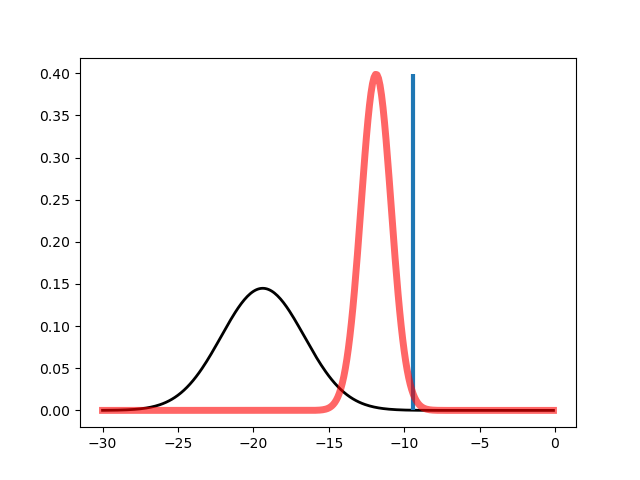

In [51]:
plot_priors(15, 16)

In [52]:
def calc_posteriors(water_prior, land_prior):
    evidence = (water_prior * 0.5) + (land_prior * 0.5)
    return (water_prior * 0.5) / evidence,  (land_prior * 0.5) / evidence

def plot_posteriors(x, y):
    f_post, nf_post = calc_posteriors(*calc_priors(x = x, y = y))
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, f_post, 'k-', lw=2)
    ax.vlines(x=sig0_dc.isel(x=x, y=y).SIG0.to_numpy(), ymin=-0.1, ymax=1.1, lw=3)
    ax.plot(RANGE, nf_post,'r-', lw=5, alpha=0.6)

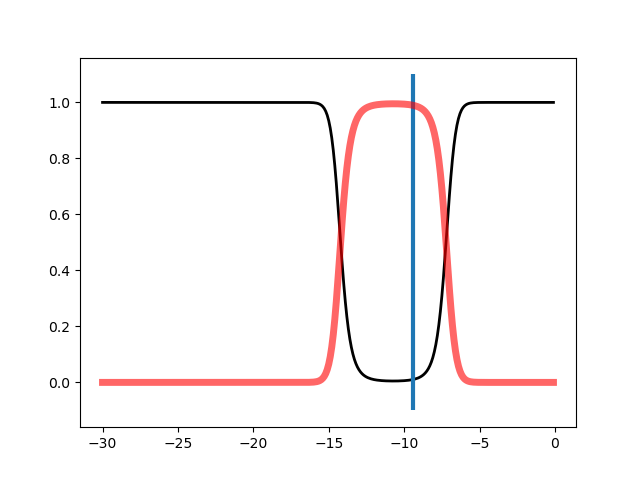

In [53]:
plot_posteriors(15, 16)

In [54]:
# initialize a map on top
m = Maps(ax=211)
m.add_feature.preset.ocean()
m.add_feature.preset.coastline()

# initialize 2 matplotlib plot-axes below the map
ax_left = m.f.add_subplot(223)
ax_left.set_ylabel("density probability")
ax_left.set_xlabel("sigma")

ax_right = m.f.add_subplot(224)
ax_right.set_ylabel("probability")
ax_right.set_xlabel("sigma")

ax_left.sharey(ax_right)

# -------- assign data to the map and plot it
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=sig0_dc.spatial_ref.crs_wkt)
m.set_shape.shade_points()
m.plot_map()


TypeError: invalid indexer array, does not have integer dtype: array(22.08042637)

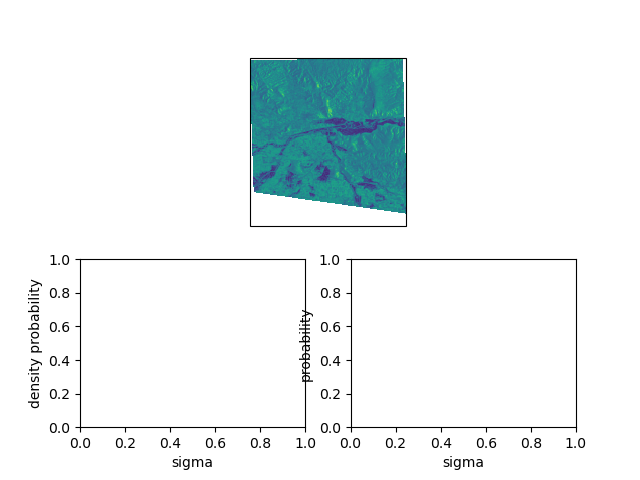

In [55]:
# -------- define a custom callback function to update the plots
def update_plots(ID, **kwargs):
    
    # get the data
    x, y = kwargs["pos"]
    y1_pdf, y2_pdf = calc_priors(x = x, y = y)

    # plot the lines and histograms
    (l,) = ax_left.plot(RANGE, y1_pdf, 'k-', lw=2)
    (r,) = ax_right.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)

    # re-compute axis limits based on the new artists
    ax_left.relim()
    ax_right.relim()
    ax_left.autoscale()
    ax_right.autoscale()

    # add all artists as "temporary pick artists" so that they
    # are removed when the next datapoint is selected
    for a in [l, r]:
        m.cb.pick.add_temporary_artist(a)

m.cb.pick.attach(update_plots)
m.cb.pick.attach.annotate()
m.cb.pick.attach.mark(permanent=False, buffer=1, fc="none", ec="r")
m.cb.pick.attach.mark(permanent=False, buffer=2, fc="none", ec="r", ls=":")
m.show()